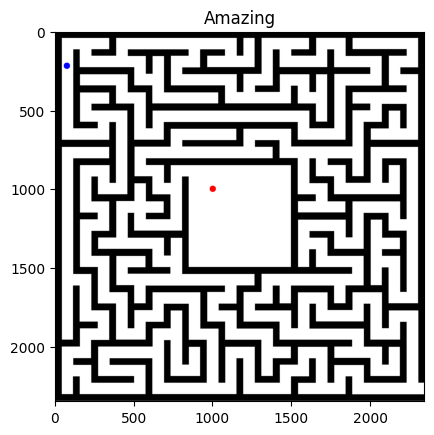

In [20]:
from matplotlib import pyplot as plt
import cv2

# Make sure to provide the correct path to the image file
img_path = 'maze.JPG'
img = cv2.imread(img_path)

# Draw circles
cv2.circle(img, (75, 220), 20, (255, 0, 0), -1)  # Red circle
cv2.circle(img, (1000, 1000), 20, (0, 0, 255), -1)    # Blue circle

# Display the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.title('Amazing')
plt.show()



In [38]:
import math 
def fixPixelValues(px):
    # convert the RGB values into floating point to avoid an overflow that will give me wrong answers
    return [ float(px[0]), float(px[1]), float(px[2]) ]

In [39]:
def getEdgeWeight(img, u, v):
    # get edge weight for edge between u, v
    i0,j0 = u[0], u[1]
    i1,j1 = v[0], v[1]
    height, width, _ = img.shape
    #print(f"Processing edge weight between ({i0}, {j0}) and ({i1}, {j1})")
    assert i0 >= 0 and j0 >= 0 and i0 < width and j0 < height # pixel position valid?
    assert i1 >= 0 and j1 >= 0 and i1 < width and j1 < height # pixel position valid?
    #print(f"horizontal distance: {i0 - i1}")
    #print(f"vertical distance: {j0 - j1}")
    assert -1 <= i0 - i1 <= 1 # edge between node and neighbor?
    #print(i0 - i1)
    assert -1 <= j0 - j1 <= 1
    #print(j0-j1)
    px1 = fixPixelValues(img[j0,i0])
    px2 = fixPixelValues(img[j1,i1])
    weight = 0.1 + (px1[0] - px2[0])**2 + (px1[1] - px2[1])**2 + (px1[2]- px2[2])**2
    #print(f"Edge weight: {weight}")
    return weight   

In [49]:
# This is a useful function that given a list of (x,y) values, 
# draw a series of red lines between each coordinate and next to 
# show the path in the image
def drawPath(img, path, pThick=50):
    v = path[0]
    x0, y0 = v[0], v[1]
    for v in path:
        x, y = v[0], v[1]
        cv2.line(img,(x,y), (x0,y0), (255,0,0),pThick)
        x0, y0 = x,y
        

In [42]:
class Vertex: # This is the outline for a vertex data structure
    def __init__ (self,  i, j):
        self.x = i # The x coordinate
        self.y = j  # The y coordinate
        self.d = float('inf') # the shortest path estimate
        self.processed = False # Has this vertex's final shortest path distance been computed
        self.idx_in_priority_queue = -1 # The index of this vertex in the queue
        self.pi = None # the parent vertex.

    def __eq__(self, other):
        return (self.x, self.y) == (other.x, other.y)

    def __hash__(self):
        return hash((self.x, self.y))

In [43]:
import heapq
import itertools

class PriorityQueue:
    def __init__(self):
        self.heap = []  # List to hold the heap's elements
        self.entry_finder = {}  # Mapping of vertices to entries
        self.removed = set()  # Set to keep track of removed entries
        self.counter = itertools.count()  # Unique sequence count to maintain order

    def insert(self, vertex, priority):
        """Insert a new vertex with the given priority into the priority queue."""
        if vertex in self.entry_finder:
            self.remove(vertex)
        count = next(self.counter)
        entry = [priority, count, vertex]
        self.entry_finder[vertex] = entry
        heapq.heappush(self.heap, entry)
        #print(f"Inserted {vertex} with priority {priority}")
        #print("Inserted:", vertex, "with priority:", priority)

    def remove(self, vertex):
        """Mark an existing vertex as REMOVED."""
        entry = self.entry_finder.pop(vertex, None)
        if entry:
            self.removed.add((entry[0], entry[2]))  # Add to removed set instead of calling self.remove

    def get_and_delete_min(self):
        """Remove and return the lowest priority vertex that is not marked as removed."""
        while self.heap:
            priority, count, vertex = heapq.heappop(self.heap)
            if (priority, vertex) not in self.removed:
                self.entry_finder.pop(vertex, None)  # Remove vertex from entry_finder
                return vertex
        raise KeyError("The priority queue is empty")

    def update_vertex_weight(self, vertex, new_priority):
        #print(f"Attempting to update {vertex} to new priority {new_priority}.")
        if vertex in self.entry_finder:
            current_priority = self.entry_finder[vertex][0]
            #print(f"Current priority: {current_priority}, New priority: {new_priority}")
            if current_priority > new_priority:
                #print("Updating vertex:", vertex, "from priority:", current_priority, "to new priority:", new_priority)
                self.remove(vertex)
                #print("Removed vertex:", vertex)
                vertex.d = new_priority
                self.insert(vertex, new_priority)
                #print(f"Updated {vertex} in heap.")
            else:
                print("No update needed as current priority is lower or equal.")
        else:
            print("Vertex not found in entry_finder, cannot update.")
            #print("Updated vertex:", vertex, "to new priority:", priority) 

    def is_empty(self):
        """Check if the queue is empty."""
        return not self.heap
        

In [44]:
def computeShortestPath(img, source, dest):
    height, width = img.shape[:2]
    vertices = {(j, i): Vertex(j, i) for i in range(height) for j in range(width)}

    # Initialize source vertex
    source_vertex = vertices[source]
    source_vertex.d = 0
    pq = PriorityQueue()
    pq.insert(source_vertex, source_vertex.d)

    while not pq.is_empty():
        current_vertex = pq.get_and_delete_min()

        if (current_vertex.x, current_vertex.y) == dest:
            break  # Destination reached

        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = current_vertex.x + dx, current_vertex.y + dy
            if 0 <= nx < width and 0 <= ny < height:
                neighbor = vertices[(nx, ny)]
                new_d = current_vertex.d + getEdgeWeight(img, (current_vertex.x, current_vertex.y), (nx, ny))
                if new_d < neighbor.d:
                    neighbor.d = new_d
                    neighbor.pi = current_vertex
                    if neighbor not in pq.entry_finder:
                        pq.insert(neighbor, new_d)  # Insert neighbor if not present
                    else:
                        pq.update_vertex_weight(neighbor, new_d)  # Update if already present

    # Reconstruct the path
    path = []
    current = vertices[dest]
    if current.pi is None:
        return "Destination is not reachable from the source."
    while current:
        path.append((current.x, current.y))
        current = current.pi
    path.reverse()
    return path


In [47]:
img = cv2.imread('maze.JPG') # read an image from a file using opencv (cv2) library
p = computeShortestPath(img, (75, 220), (1000, 1000))

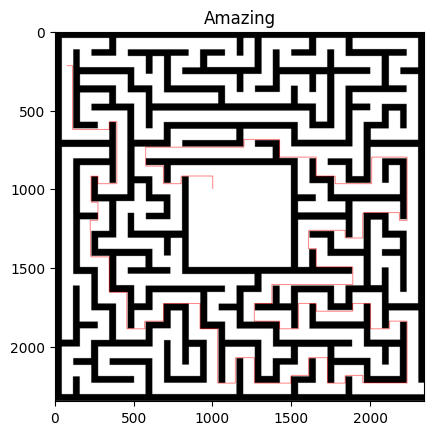

True

In [50]:
drawPath(img, p, 2)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()
cv2.imwrite('maze-solution.png', img)